In [1]:
import sys
sys.path.append("../") # to access code from rl.distribution, etc.

import numpy as np
from time import time 
from scipy.stats import poisson
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Mapping, Dict, Tuple
from rl.distribution import Categorical
from rl.markov_decision_process import FiniteMarkovDecisionProcess
from rl.dynamic_programming import policy_iteration, value_iteration, value_iteration_result

np.set_printoptions(formatter={'float': lambda x: "{0:.3f}".format(x)})
plt.rcParams['figure.figsize'] = (15, 7)

# Question 1
We know that:
$$
v_0 = \begin{bmatrix}
    10.0 \\ 1.0 \\ 0.0
\end{bmatrix}
$$
By using the value iteration algorithm, the first iteration gives us:
$$
\begin{aligned}
    v_1 \left( s_1 \right) & = \max \left( 8.0 + 0.2 \times 10.0 + 0.6 \times 1.0, 10.0 + 0.1 \times 10.0 + 0.2 \times 1.0 \right)
    \\ \therefore v_1 \left( s_1 \right) & = \max \left( 10.6, 11.2 \right) = 11.2 
    \\ v_1 \left( s_2 \right) & = \max \left( 1.0 + 0.3 \times 10.0 + 0.3 \times 1.0, -1.0 + 0.5 \times 10.0 + 0.3 \times 1.0 \right)
    \\ \therefore v_1 \left( s_2 \right) & = \max \left( 4.3, 4.3 \right) = 4.3
    \\ v_1 \left( s_3 \right) & = 0.0 ~ \left({\text{since it's a terminal state}}\right)
    \\ \therefore v_1 & = \begin{bmatrix}
        11.2 \\ 4.3 \\ 0.0
    \end{bmatrix}
\end{aligned}
$$
The optimal policy $\pi_1$ is to choose the action that gives us the best reward from that state:
$$
\begin{aligned}
    \pi_1 \left( s_1 \right) & = \text{arg}\max_{\{a_1, a_2\}} (10.6, 11.2) = a_2
    \\ \pi_1 \left( s_2 \right) & = \text{arg}\max_{\{a_1, a_2\}} (4.3, 4.3) = a_2 ~ \left({\text{arbitrarily chose} ~ a_2}\right)
\end{aligned}
$$
The second iteration of the value iteration algorithm gives us:
$$
\begin{aligned}
    v_2 \left( s_1 \right) & = \max \left( 8.0 + 0.2 \times 11.2 + 0.6 \times 4.3, 10.0 + 0.1 \times 11.2 + 0.2 \times 4.3 \right)
    \\ \therefore v_2 \left( s_1 \right) & = \max \left( 12.82, 11.98 \right) = 12.82
    \\ v_2 \left( s_2 \right) & = \max \left( 1.0 + 0.3 \times 11.2 + 0.3 \times 4.3, -1.0 + 0.5 \times 11.2 + 0.3 \times 4.3 \right)
    \\ \therefore v_2 \left( s_2 \right) & = \max \left( 5.65, 5.89 \right) = 5.89
    \\ v_2 \left( s_3 \right) & = 0.0 ~ \left(\text{since it's a terminal state}\right)
    \\ \therefore v_2 & = \begin{bmatrix}
        12.82 \\ 5.89 \\ 0.00
    \end{bmatrix}
\end{aligned}
$$
The optimal policy is thus:
$$
\begin{aligned}
    \pi_2 \left( s_1 \right) & = \text{arg}\max_{\{a_1, a_2\}} (12.82, 11.98) = a_1
    \\ \pi_2 \left( s_2 \right) & = \text{arg}\max_{\{a_1, a_2\}} (5.65, 5.89) = a_2
\end{aligned}
$$
Suppose $k > 2$. We know that:
$$
\begin{aligned}
    q_k \left( s_1 \right) & = \max(8 + 0.2 v_{k-1} \left( s_1 \right) + 0.6 v_{k-1} \left( s_2 \right), 10 + 0.1 v_{k-1} \left( s_1 \right) + 0.2 v_{k-1} \left( s_2 \right))
    \\ q_k \left( s_2 \right) & = \max(1 + 0.3 v_{k-1} \left( s_1 \right) + 0.3 v_{k-1} \left( s_2 \right), -1 + 0.5 v_{k-1} \left( s_1 \right) + 0.3 v_{k-1} \left( s_2 \right))
\end{aligned}
$$

# Question 2

In [2]:
@dataclass(frozen = True)
class Position:
	position : int


ActionMapping = Mapping[Position, Mapping[str, Categorical[Tuple[Position, float]]]]


class FrogEscape(FiniteMarkovDecisionProcess[Position, str]):
	def __init__(self, length : int):
		self.length = length # resembles n in the problem
		super().__init__(self.get_action_transition_reward_map())

	def get_action_transition_reward_map(self) -> ActionMapping:
		d : Dict[Position, Dict[str, Categorical[Tuple[Position, float]]]] = {}

		for state in range(1, self.length):
			state = Position(position = state)

			inner_dict : Dict[str, Categorical[Tuple[Position, float]]] = {}

			# if the frog croaks sound A...
			dict_A = {}

			dict_A[(Position(position = state.position - 1), 0.0)] = state.position / self.length
			if state.position + 1 == self.length: # if the frog escapes, reward = 1.0, else 0.0
				dict_A[(Position(position = self.length), 1.0)] = 1 - state.position / self.length

			else:
				dict_A[(Position(position = state.position + 1), 0.0)] = 1 - state.position / self.length

			inner_dict['A'] = Categorical(dict_A)

			# if the frog croaks sound B... if the frog escapes, reward = 1.0, else 0.0
			dict_B = {(Position(position = i), 0.0) : 1. / self.length for i in range(self.length) if i != state.position}
			dict_B[(Position(position = self.length), 1.0)] = 1. / self.length
			inner_dict['B'] = Categorical(dict_B)

			d[state] = inner_dict

		return d


def done(v1 : Dict[Position, float], v2 : Dict[Position, float], tol : float):
	'''
	this function takes in two dictionaries, converts them to numpy
	arrays and then returns True if the maximum absolute value across
	one array and the other is smaller than the specified tolerance

	parameters:
	v1: a dictionary with states as the keys and the elements
		in the value function as the values
	v2: a dictionary with states as the keys and the elements
		in the value function as the values
	tol: the specified tolerance

	returns:
	--------
	True if the maximum difference is less than TOLERANCE
	False otherwise
	'''
	array1 = np.array([i for i in v1.values()])
	array2 = np.array([i for i in v2.values()])

	return np.linalg.norm(array1 - array2, ord = np.inf) < tol

### I set up functions to time the two algorithms:

In [3]:
def using_value_iteration(length : int, TOLERANCE : float) -> float:
	'''
	this function times the value_iteration algorithm for a given length

	parameters:
	-----------
	@length: the length of the river for the MDP
	@TOLERANCE: the tolerance for stopping the iteration

	returns:
	--------
	@duration: the time it took to run the algorithm (in milliseconds)
	'''
	start_time = time()
	frog_mdp : FiniteMarkovDecisionProcess[Position, str] = FrogEscape(length = length)
	old_vf : Dict[Position, float] = {s: 0.0 for s in frog_mdp.non_terminal_states}
	vf_generator = value_iteration(mdp = frog_mdp, gamma = 1.0)
	new_vf = next(vf_generator)
	for new_vf in vf_generator:
		if done(old_vf, new_vf, TOLERANCE):
			break
		old_vf = new_vf

	return (time() - start_time) * 1000.0


def using_policy_iteration(length : int, TOLERANCE : float) -> float:
	'''
	this function times the policy_iteration algorithm for a given length

	parameters:
	-----------
	@length: the length of the river for the MDP
	@TOLERANCE: the tolerance for stopping the iteration

	returns:
	--------
	@duration: the time it took to run the algorithm (in milliseconds)
	'''
	start_time = time()
	frog_mdp : FiniteMarkovDecisionProcess[Position, str] = FrogEscape(length = length)
	old_vf = {s: 0.0 for s in frog_mdp.non_terminal_states}
	vf_generator = policy_iteration(mdp = frog_mdp, gamma = 1.0)
	new_vf = next(vf_generator)
	for new_vf, new_pi in vf_generator:
		if done(old_vf, new_vf, TOLERANCE):
			break
		old_vf = new_vf

	return (time() - start_time) * 1000.0

### I then run the analysis on the two and plot the resulting graphs:

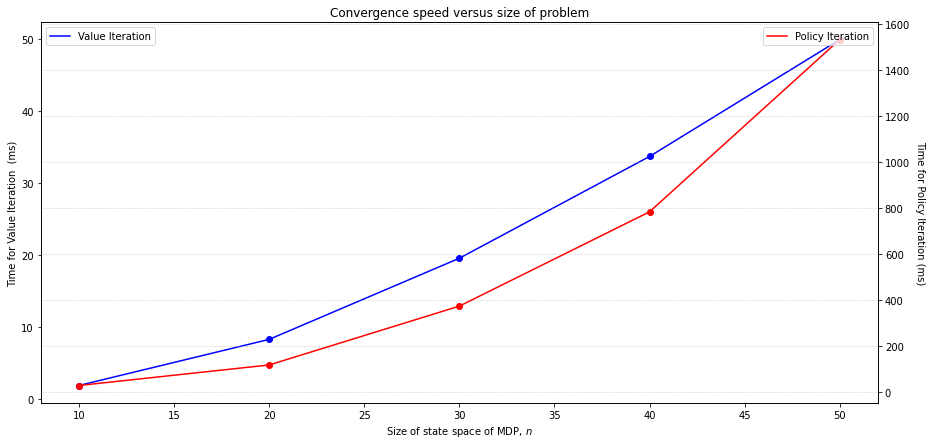

In [4]:
TOLERANCE = 1e-2
n_sim = 3 # number of simulations to run for finding average time
lengths = range(10, 51, 10)
value_times = [] # will store the average time for value iteration
policy_times = [] # will store the average time for policy iteration

# for each length, run n_sim number of simulations
# and then calculate the average time taken for
# the algorithm to converge
for length in lengths:
    values_tmp = []
    policy_tmp = []

    for _ in range(n_sim):
        values_tmp.append(using_value_iteration(length, TOLERANCE))
        policy_tmp.append(using_policy_iteration(length, TOLERANCE))

    value_times.append(np.mean(values_tmp))
    policy_times.append(np.mean(policy_tmp))

# plotting the graph of the size of state space
# versus the time taken to run the algorithm!
fig, ax1 = plt.subplots()
ax1.plot(lengths, value_times, label = 'Value Iteration', color = 'blue')
ax1.scatter(lengths, value_times, color = 'blue')

ax2 = ax1.twinx()

ax2.plot(lengths, policy_times, label = 'Policy Iteration', color = 'red')
ax2.scatter(lengths, policy_times, color = 'red')

ax1.set_title("Convergence speed versus size of problem")
ax1.set_xlabel("Size of state space of MDP, $n$")
ax1.set_ylabel("Time for Value Iteration  (ms)")
ax2.set_ylabel("Time for Policy Iteration (ms)", rotation = -90, labelpad=15)

ax1.legend(loc = 'upper left')
ax2.legend(loc = 'upper right')
plt.grid(alpha = 0.75, linestyle = ":")
plt.show()

# Not doing Question 3 (as of Feb 5)
# Question 4:

In [5]:
@dataclass(frozen=True)
class InventoryState:
    on_hand_1: int
    on_order_1: int
    on_hand_2: int
    on_order_2: int

    def inventory_position_1(self) -> int:
        return self.on_hand_1 + self.on_order_1

    def inventory_position_2(self) -> int:
        return self.on_hand_2 + self.on_order_2


InvOrderMapping = Mapping[
    InventoryState,
    Mapping[Tuple[int, int, int], Categorical[Tuple[InventoryState, float]]]
]


class TwoStoresInventoryControl(FiniteMarkovDecisionProcess[InventoryState, Tuple[int, int, int]]):

    def __init__(
        self,
        capacity_1: int,
        capacity_2: int,
        poisson_lambda_1: float,
        poisson_lambda_2: float,
        holding_cost_1: float,
        holding_cost_2: float,
        stockout_cost_1: float,
        stockout_cost_2: float,
        transport_cost_1: float,
        transport_cost_2: float
    ):
        self.capacity_1: int = capacity_1
        self.poisson_lambda_1: float = poisson_lambda_1
        self.holding_cost_1: float = holding_cost_1
        self.stockout_cost_1: float = stockout_cost_1

        self.capacity_2: int = capacity_2
        self.poisson_lambda_2: float = poisson_lambda_2
        self.holding_cost_2: float = holding_cost_2
        self.stockout_cost_2: float = stockout_cost_2

        self.transport_cost_1: float = transport_cost_1
        self.transport_cost_2: float = transport_cost_2

        self.demand_distribution_1 = poisson(poisson_lambda_1)
        self.demand_distribution_2 = poisson(poisson_lambda_2)
        super().__init__(self.get_action_transition_reward_map())

    def get_action_transition_reward_map(self) -> InvOrderMapping:
        d: Dict[InventoryState, Dict[Tuple[int, int, int], Categorical[Tuple[InventoryState, float]]]] = {}

        for alpha_1 in range(self.capacity_1 + 1):
            for beta_1 in range(self.capacity_1 + 1 - alpha_1):
                for alpha_2 in range(self.capacity_2 + 1):
                    for beta_2 in range(self.capacity_2 + 1 - alpha_2):
                        state: InventoryState = InventoryState(on_hand_1=alpha_1, on_order_1=beta_1, on_hand_2=alpha_2, on_order_2=beta_2)
                        ip_1: int = state.inventory_position_1()
                        ip_2: int = state.inventory_position_2()
                        base_reward: float = - self.holding_cost_1 * alpha_1 - self.holding_cost_2 * alpha_2
                        d1: Dict[Tuple[int, int, int], Categorical[Tuple[InventoryState, float]]] = {}

                        for order_1 in range(self.capacity_1 - ip_1 + 1):
                            for order_2 in range(self.capacity_2 - ip_2 + 1):
                                for transfer in range(-min(alpha_2, self.capacity_1 - alpha_1 - beta_1), min(alpha_1, self.capacity_2 - alpha_2 - beta_2) + 1):
                                    sr_probs_dict: Dict[Tuple[InventoryState, float], float] = {}
                                    prob_1: float = 1 - self.demand_distribution_1.cdf(ip_1 - 1)
                                    prob_2: float = 1 - self.demand_distribution_2.cdf(ip_2 - 1)

                                    K_1 = self.transport_cost_1 if order_1 == 0 or order_2 == 0 else 0.0
                                    K_1 = min(1, order_1) * self.transport_cost_1 + min(1, order_2) * self.transport_cost_1
                                    K_2 = self.transport_cost_2 if transfer != 0 else 0.0

                                    for i in range(ip_1):
                                        for j in range(ip_2):
                                            if i < alpha_1 + beta_1 - transfer and j < alpha_2 + beta_2 + transfer:
                                                reward: float = base_reward - K_1 - K_2
                                                sr_probs_dict[(InventoryState(ip_1 - i, order_1 - transfer, ip_2 - j, order_2 + transfer), reward)] = self.demand_distribution_1.pmf(i) * self.demand_distribution_2.pmf(j)

                                            elif j < alpha_2 + beta_2 + transfer:
                                                reward: float = base_reward - self.stockout_cost_1 * (prob_1 * (self.poisson_lambda_1 - ip_1) + ip_1 * self.demand_distribution_1.pmf(ip_1)) - K_1 - K_2
                                                sr_probs_dict[(InventoryState(0, order_1 - transfer, ip_2 - j, order_2 + transfer), reward)] = prob_1 * self.demand_distribution_2.pmf(j)
                                            
                                            elif i < alpha_1 + beta_1 - transfer:
                                                reward: float = base_reward - self.stockout_cost_2 * (prob_2 * (self.poisson_lambda_2 - ip_2) + ip_2 * self.demand_distribution_2.pmf(ip_2)) - K_1 - K_2
                                                sr_probs_dict[(InventoryState(ip_1 - i, order_1 - transfer, 0, order_2 + transfer), reward)] = prob_2 * self.demand_distribution_1.pmf(i)

                                    # when the inventory position for both stores are less than the ordered and transferred units
                                    reward: float = base_reward - self.stockout_cost_1 * (prob_1 * (self.poisson_lambda_1 - ip_1) + ip_1 * self.demand_distribution_1.pmf(ip_1)) - self.stockout_cost_2 * (prob_2 * (self.poisson_lambda_2 - ip_2) + ip_2 * self.demand_distribution_2.pmf(ip_2)) - K_1 - K_2
                                    sr_probs_dict[(InventoryState(0, order_1 - transfer, 0, order_2 + transfer), reward)] = prob_1 * prob_2

                                    d1[(order_1, order_2, transfer)] = Categorical(sr_probs_dict)

                        d[state] = d1
        return d

### I create an instance of the Markov decision process and then obtain the corresponding optimal value function and policy:

In [6]:
capacity_1 = 4
capacity_2 = 4
poisson_lambda_1 = 2.0
poisson_lambda_2 = 1.0
holding_cost_1 = 1.0
holding_cost_2 = 3.0
stockout_cost_1 = 10.0
stockout_cost_2 = 24.0
transport_cost_1 = 10.0
transport_cost_2 = 9.0

user_gamma = 0.9

si_mdp: FiniteMarkovDecisionProcess[InventoryState, Tuple[int, int, int]] =\
    TwoStoresInventoryControl(
        capacity_1=capacity_1,
        capacity_2=capacity_2,
        poisson_lambda_1=poisson_lambda_1,
        poisson_lambda_2=poisson_lambda_2,
        holding_cost_1=holding_cost_1,
        holding_cost_2=holding_cost_2,
        stockout_cost_1=stockout_cost_1,
        stockout_cost_2=stockout_cost_2,
        transport_cost_1=transport_cost_1,
        transport_cost_2=transport_cost_2
    )

In [7]:
opt_vf_vi, opt_policy_vi = value_iteration_result(si_mdp, gamma=user_gamma)

# print(opt_vf_vi)
# print()
# print(opt_policy_vi)

In [8]:
for s, a in opt_policy_vi.action_for.items():
    on_hand1 = s.on_hand_1
    on_order1 = s.on_order_1
    on_hand2 = s.on_hand_2
    on_order2 = s.on_order_2
    store_order1 = a[0]
    store_order2 = a[1]
    store1_transferto_store2 = a[2] if a[2] > 0 else 0
    store2_transferto_store1 = abs(a[2]) if a[2] < 0 else 0

    print((on_hand1, on_order1, on_hand2, on_order2, store_order1, store_order2, store1_transferto_store2, store2_transferto_store1))

(0, 0, 0, 0, 4, 3, 0, 0)
(0, 0, 0, 1, 4, 3, 0, 0)
(0, 0, 0, 2, 4, 2, 0, 0)
(0, 0, 0, 3, 4, 1, 0, 0)
(0, 0, 0, 4, 2, 0, 0, 0)
(0, 0, 1, 0, 0, 0, 0, 1)
(0, 0, 1, 1, 0, 0, 0, 1)
(0, 0, 1, 2, 0, 0, 0, 1)
(0, 0, 1, 3, 0, 0, 0, 1)
(0, 0, 2, 0, 0, 0, 0, 2)
(0, 0, 2, 1, 0, 0, 0, 2)
(0, 0, 2, 2, 0, 0, 0, 2)
(0, 0, 3, 0, 0, 0, 0, 3)
(0, 0, 3, 1, 0, 0, 0, 3)
(0, 0, 4, 0, 0, 0, 0, 4)
(0, 1, 0, 0, 3, 4, 0, 0)
(0, 1, 0, 1, 3, 3, 0, 0)
(0, 1, 0, 2, 3, 2, 0, 0)
(0, 1, 0, 3, 0, 0, 0, 0)
(0, 1, 0, 4, 0, 0, 0, 0)
(0, 1, 1, 0, 0, 0, 0, 1)
(0, 1, 1, 1, 0, 0, 0, 1)
(0, 1, 1, 2, 0, 0, 0, 1)
(0, 1, 1, 3, 0, 0, 0, 1)
(0, 1, 2, 0, 0, 0, 0, 1)
(0, 1, 2, 1, 0, 0, 0, 1)
(0, 1, 2, 2, 0, 0, 0, 1)
(0, 1, 3, 0, 0, 0, 0, 1)
(0, 1, 3, 1, 0, 0, 0, 1)
(0, 1, 4, 0, 0, 0, 0, 1)
(0, 2, 0, 0, 2, 4, 0, 0)
(0, 2, 0, 1, 2, 3, 0, 0)
(0, 2, 0, 2, 0, 2, 0, 0)
(0, 2, 0, 3, 0, 0, 0, 0)
(0, 2, 0, 4, 0, 0, 0, 0)
(0, 2, 1, 0, 0, 0, 0, 1)
(0, 2, 1, 1, 0, 0, 0, 1)
(0, 2, 1, 2, 0, 0, 0, 1)
(0, 2, 1, 3, 0, 0, 0, 1)
(0, 2, 2, 0, 0, 0, 0, 1)


This makes sense because when we don't have anything in either stores, the optimal action is to order the maximum quantity possible for both stores, and then transfer to the other store if it's low on inventory, etc.